In [1]:
from Backtest import Backtest,Position,Bid
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
#warnings.filterwarnings("ignore")

# Bid Class Demo
## intialize a Bid instance with four variables
- ticker
- shares
- price
- bid_type (1 as buy, 0 as sell)


In [2]:
# a bid to buy 100 shares of Apple at $163.43
buy_apple_100 = Bid(ticker = "AAPL", shares = 100, price = 163.43, bid_type = 1)

#the show method could be used for debugging
buy_apple_100.show()

Buying:
Ticker: AAPL
Shares: 100
Price: 163.43


# 

# Position class demo
## intialize a Position  instance with a bid instance

In [3]:
apple_position = Position(buy_apple_100)
apple_position.show()

Ticker: AAPL
Shares_held: 100
Latest_price: 163.43
weighted_average_cost: 163.43
----------------
Purchasing History
Price	Shares
163.43	100


## Change the position with another bid

In [4]:
buy_apple_50 = Bid(ticker = "AAPL", shares = 50, price = 163.13, bid_type = 1)
apple_position.change_position(buy_apple_50)
apple_position.show()

Ticker: AAPL
Shares_held: 150
Latest_price: 163.13
weighted_average_cost: 163.33
----------------
Purchasing History
Price	Shares
163.43	100
163.13	50


## Selling a stock

In [5]:
sell_apple_100 = Bid(ticker = 'AAPL', shares = 100, price = 165.24, bid_type = 0)

#if selling a stock, the change_position method will return a cost
#this cost will be the lowest part of costs in purchasing history 
cost_of_buying_100 = apple_position.change_position(sell_apple_100)
apple_position.show()

Ticker: AAPL
Shares_held: 50
Latest_price: 165.24
weighted_average_cost: 163.43
----------------
Purchasing History
Price	Shares
163.43	50


In [6]:
income = sell_apple_100.shares * sell_apple_100.price
print("Income: ", income)
print("Cost: ", cost_of_buying_100)
print("Pnl for this single trade: ", income - cost_of_buying_100 )

Income:  16524.0
Cost:  16328.0
Pnl for this single trade:  196.0


In [7]:
apple_position.change_position(sell_apple_100)

Try to sell 100 shares, but only got 50 shares.


0

# 

# A demo strategy
## Randomly buy 10 stocks at 9:30 everyday and sell at 16:00
## a strategy function has four parameters, which are:
- ti: current datetime 
- df: all historical data up to ti
- positions: a dictionary of all current positions (k: string of ticker, v: an instance of this ticker's Position)
- cash: cash avaliable

## and it should return a list of Bid instances
## *This is the part where you implement your strategy

In [2]:
def my_strategy(ti,df,positions,cash):
    
    if ti.minute == 0 or ti.minute == 30:
        print("================={}=================".format(ti))
    bid_list = []
    
    #buy
    if ti.hour == 9 and ti.minute == 30:
        for i in range(10):
            ticker = random.choice(df.columns)
            
            #latest price
            price = df.iloc[-1][ticker]
            
            bid = Bid(ticker = ticker, shares = 100, price = price,bid_type = 1)
            bid_list.append(bid)
            bid.show()
        return bid_list
    
    #sell
    if ti.hour == 16 and ti.minute == 0:
        #for all current positions
        for pos in positions.values():
            #ticker
            ticker = pos.ticker
            #latest price
            price = df.iloc[-1][pos.ticker]
            #shares held in current position
            shares_held = pos.shares
            
            bid = Bid(ticker = ticker,shares = shares_held,price = price,bid_type = 0)
            bid_list.append(bid)
            bid.show()
        return bid_list
    return bid_list

# Load sample data

In [7]:
data = pd.read_csv("test_data.csv",index_col=[0])
data.index = pd.to_datetime(data.index)
data.tail(5)

,cat,mcd,etsy,twtr,kmi,gme,celg,wdc,ups,nflx,...,ms,abt,jpm,lb,rad,bbby,nvda,biib,aal,vz
2019-04-23 16:26:00,135.824,187.434,65.5,39.94,18.0405,8.89,93.67,52.2541,107.148,382.32,...,44.9874,74.0433,107.250,23.8588,9.9099,15.5828,190.259,230.45,33.5206,53.0593
2019-04-23 16:27:00,135.728,187.434,65.5,39.91,18.0405,8.89,93.67,52.2541,107.148,382.00,...,44.9874,74.0433,107.250,23.8588,9.7200,15.5828,190.060,230.25,33.5206,53.0593
2019-04-23 16:28:00,135.824,187.434,65.5,39.91,18.0495,8.89,93.67,52.2541,107.148,381.66,...,44.9874,74.0433,107.259,23.8588,9.7200,15.5828,190.060,230.25,33.5206,53.0964
2019-04-23 16:29:00,135.719,187.204,65.5,39.91,18.0495,8.89,93.67,52.2541,107.148,381.66,...,44.9874,74.0433,107.250,23.8588,9.7101,15.5828,189.811,230.40,33.5206,53.0593
2019-04-23 16:30:00,135.929,187.204,65.5,39.85,18.0226,8.89,93.67,52.2541,107.148,381.97,...,44.9874,74.0433,107.250,23.8588,9.7101,15.5828,190.060,230.21,33.5206,53.0593


In [8]:
data = data.sort_index()

In [10]:
data.to_csv("test_data.csv",index = True)

# Backtest Demo
## initialize a Backtest instance with data and strategy, in default:
- initial_amount = 100000
- has_tc = True (0.2% of transaction cost)

In [4]:
random_strat = Backtest(data,my_strategy, has_tc = False)

In [22]:
random_strat.backtest_full()

=================2019-04-05 09:30:00=================
Buying:
Ticker: hal
Shares: 100
Price: 29.1758
Buying:
Ticker: dd
Shares: 100
Price: 36.6447
Buying:
Ticker: intu
Shares: 100
Price: 260.501
Buying:
Ticker: lrcx
Shares: 100
Price: 187.956
Buying:
Ticker: luv
Shares: 100
Price: 52.7929
Buying:
Ticker: ma
Shares: 100
Price: 234.306
Buying:
Ticker: twtr
Shares: 100
Price: 34.6301
Buying:
Ticker: axp
Shares: 100
Price: 107.192
Buying:
Ticker: isrg
Shares: 100
Price: 574.1
Buying:
Ticker: s
Shares: 100
Price: 5.67
Not enough cash to build a position for isrg
=================2019-04-05 10:00:00=================
=================2019-04-05 10:30:00=================
=================2019-04-05 11:00:00=================
=================2019-04-05 11:30:00=================
=================2019-04-05 12:00:00=================
=================2019-04-05 12:30:00=================
=================2019-04-05 13:00:00=================
=================2019-04-05 13:30:00=================
====

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.


=================2019-04-02 10:30:00=================
=================2019-04-02 11:00:00=================
=================2019-04-02 11:30:00=================
=================2019-04-02 12:00:00=================
=================2019-04-02 12:30:00=================
=================2019-04-02 13:00:00=================
=================2019-04-02 13:30:00=================
=================2019-04-02 14:00:00=================
=================2019-04-02 14:30:00=================
=================2019-04-02 15:00:00=================
=================2019-04-02 15:30:00=================
=================2019-04-02 16:00:00=================
Selling
Ticker: mu
Shares: 100
Price: 42.45
Selling
Ticker: xom
Shares: 100
Price: 72.7152
Selling
Ticker: unh
Shares: 100
Price: 237.356
Selling
Ticker: dnr
Shares: 100
Price: 2.19
Selling
Ticker: aal
Shares: 100
Price: 32.5536
Selling
Ticker: biib
Shares: 100
Price: 233.27
Selling
Ticker: abbv
Shares: 100
Price: 74.4813
Selling
Ticker: dis
Shares:

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-02 16:30:00=================
=================2019-04-03 09:30:00=================
Buying:
Ticker: unp
Shares: 100
Price: 163.859
Buying:
Ticker: o
Shares: 100
Price: 67.1119
Buying:
Ticker: aks
Shares: 100
Price: 2.87
Buying:
Ticker: lrcx
Shares: 100
Price: 181.309
Buying:
Ticker: ups
Shares: 100
Price: 107.61
Buying:
Ticker: s
Shares: 100
Price: 5.66
Buying:
Ticker: stz
Shares: 100
Price: 172.351
Buying:
Ticker: ibm
Shares: 100
Price: 131.855
Buying:
Ticker: clf
Shares: 100
Price: 10.3372
Buying:
Ticker: vlo
Shares: 100
Price: 77.4249
=================2019-04-03 10:00:00=================
=================2019-04-03 10:30:00=================
=================2019-04-03 11:00:00=================
=================2019-04-03 11:30:00=================
=================2019-04-03 12:00:00=================
=================2019-04-03 12:30:00=================
=================2019-04-03 13:00:00=================
=================2019-04-03 13:30:00=================


/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-04 10:00:00=================
=================2019-04-04 10:30:00=================
=================2019-04-04 11:00:00=================
=================2019-04-04 11:30:00=================
=================2019-04-04 12:00:00=================
=================2019-04-04 12:30:00=================
=================2019-04-04 13:00:00=================
=================2019-04-04 13:30:00=================
=================2019-04-04 14:00:00=================
=================2019-04-04 14:30:00=================
=================2019-04-04 15:00:00=================
=================2019-04-04 15:30:00=================
=================2019-04-04 16:00:00=================
Selling
Ticker: cop
Shares: 100
Price: 61.5528
Selling
Ticker: kss
Shares: 100
Price: 68.0104
Selling
Ticker: fdx
Shares: 100
Price: 182.679
Selling
Ticker: hpq
Shares: 100
Price: 18.578
Selling
Ticker: ko
Shares: 100
Price: 43.8673
Selling
Ticker: mrk
Shares: 100
Price: 77.7617
Selling
Ticker: ci

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-04 16:30:00=================
=================2019-04-26 09:30:00=================
Buying:
Ticker: chk
Shares: 100
Price: 579.82
Buying:
Ticker: o
Shares: 100
Price: 65.1055
Buying:
Ticker: wba
Shares: 100
Price: 49.2488
Buying:
Ticker: ctl
Shares: 100
Price: 10.1056
Buying:
Ticker: anet
Shares: 100
Price: 317.28
Buying:
Ticker: csco
Shares: 100
Price: 53.1076
Buying:
Ticker: vlo
Shares: 100
Price: 82.2418
Buying:
Ticker: tsla
Shares: 100
Price: 49.083
Buying:
Ticker: msft
Shares: 100
Price: 127.402
Buying:
Ticker: nwl
Shares: 100
Price: 12.3975
Not enough cash to build a position for anet
Not enough cash to build a position for msft
=================2019-04-26 10:00:00=================
=================2019-04-26 10:30:00=================
=================2019-04-26 11:00:00=================
=================2019-04-26 11:30:00=================
=================2019-04-26 12:00:00=================
=================2019-04-26 12:30:00=================
=========

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-17 10:30:00=================
=================2019-04-17 11:00:00=================
=================2019-04-17 11:30:00=================
=================2019-04-17 12:00:00=================
=================2019-04-17 12:30:00=================
=================2019-04-17 13:00:00=================
=================2019-04-17 13:30:00=================
=================2019-04-17 14:00:00=================
=================2019-04-17 14:30:00=================
=================2019-04-17 15:00:00=================
=================2019-04-17 15:30:00=================
=================2019-04-17 16:00:00=================
Selling
Ticker: hal
Shares: 100
Price: 30.1496
Selling
Ticker: x
Shares: 100
Price: 16.3983
Selling
Ticker: swks
Shares: 100
Price: 88.423
Selling
Ticker: wm
Shares: 100
Price: 101.81
Selling
Ticker: gs
Shares: 100
Price: 199.712
Selling
Ticker: stz
Shares: 100
Price: 186.252
Selling
Ticker: ual
Shares: 100
Price: 89.24
Selling
Ticker: vlo
Shares: 10

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-10 10:00:00=================
=================2019-04-10 10:30:00=================
=================2019-04-10 11:00:00=================
=================2019-04-10 11:30:00=================
=================2019-04-10 12:00:00=================
=================2019-04-10 12:30:00=================
=================2019-04-10 13:00:00=================
=================2019-04-10 13:30:00=================
=================2019-04-10 14:00:00=================
=================2019-04-10 14:30:00=================
=================2019-04-10 15:00:00=================
=================2019-04-10 15:30:00=================
=================2019-04-10 16:00:00=================
Selling
Ticker: fdx
Shares: 100
Price: 186.018
Selling
Ticker: pep
Shares: 100
Price: 116.102
Selling
Ticker: brk
Shares: 100
Price: 204.52
Selling
Ticker: jpm
Shares: 100
Price: 99.4158
Selling
Ticker: amgn
Shares: 100
Price: 184.522
Selling
Ticker: ko
Shares: 100
Price: 44.1793
=================

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-11 10:30:00=================
=================2019-04-11 11:00:00=================
=================2019-04-11 11:30:00=================
=================2019-04-11 12:00:00=================
=================2019-04-11 12:30:00=================
=================2019-04-11 13:00:00=================
=================2019-04-11 13:30:00=================
=================2019-04-11 14:00:00=================
=================2019-04-11 14:30:00=================
=================2019-04-11 15:00:00=================
=================2019-04-11 15:30:00=================
=================2019-04-11 16:00:00=================
Selling
Ticker: jcp
Shares: 100
Price: 1.25
Selling
Ticker: etsy
Shares: 100
Price: 67.65
Selling
Ticker: fb
Shares: 100
Price: 177.51
Selling
Ticker: lly
Shares: 100
Price: 120.622
Selling
Ticker: oxy
Shares: 100
Price: 61.6463
Selling
Ticker: nke
Shares: 100
Price: 83.5295
Selling
Ticker: f
Shares: 100
Price: 8.8089
Selling
Ticker: nvda
Shares: 100

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-11 16:30:00=================
=================2019-04-16 09:30:00=================
Buying:
Ticker: msft
Shares: 100
Price: 118.843
Buying:
Ticker: xom
Shares: 100
Price: 72.2327
Buying:
Ticker: goog
Shares: 100
Price: 1223.63
Buying:
Ticker: fisv
Shares: 100
Price: 86.48
Buying:
Ticker: ms
Shares: 100
Price: 44.0848
Buying:
Ticker: oxy
Shares: 100
Price: 58.3289
Buying:
Ticker: atvi
Shares: 100
Price: 45.4909
Buying:
Ticker: etsy
Shares: 100
Price: 66.4055
Buying:
Ticker: clf
Shares: 100
Price: 9.893
Buying:
Ticker: mcd
Shares: 100
Price: 184.557
Not enough cash to build a position for goog
=================2019-04-16 10:00:00=================
=================2019-04-16 10:30:00=================
=================2019-04-16 11:00:00=================
=================2019-04-16 11:30:00=================
=================2019-04-16 12:00:00=================
=================2019-04-16 12:30:00=================
=================2019-04-16 13:00:00=================

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-16 16:30:00=================
=================2019-04-29 09:30:00=================
Buying:
Ticker: ms
Shares: 100
Price: 45.7969
Buying:
Ticker: wba
Shares: 100
Price: 49.4216
Buying:
Ticker: adi
Shares: 100
Price: 110.28
Buying:
Ticker: o
Shares: 100
Price: 65.5235
Buying:
Ticker: wba
Shares: 100
Price: 49.4216
Buying:
Ticker: unh
Shares: 100
Price: 230.339
Buying:
Ticker: jpm
Shares: 100
Price: 108.401
Buying:
Ticker: mrk
Shares: 100
Price: 72.841
Buying:
Ticker: hpq
Shares: 100
Price: 18.2866
Buying:
Ticker: dnr
Shares: 100
Price: 2.3
=================2019-04-29 10:00:00=================
=================2019-04-29 10:30:00=================
=================2019-04-29 11:00:00=================
=================2019-04-29 11:30:00=================
=================2019-04-29 12:00:00=================
=================2019-04-29 12:30:00=================
=================2019-04-29 13:00:00=================
=================2019-04-29 13:30:00=================

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.


=================2019-04-18 10:00:00=================
=================2019-04-18 10:30:00=================
=================2019-04-18 11:00:00=================
=================2019-04-18 11:30:00=================
=================2019-04-18 12:00:00=================
=================2019-04-18 12:30:00=================
=================2019-04-18 13:00:00=================
=================2019-04-18 13:30:00=================
=================2019-04-18 14:00:00=================
=================2019-04-18 14:30:00=================
=================2019-04-18 15:00:00=================
=================2019-04-18 15:30:00=================
=================2019-04-18 16:00:00=================
Selling
Ticker: nvda
Shares: 100
Price: 185.172
Selling
Ticker: tsla
Shares: 100
Price: 54.652
Selling
Ticker: aapl
Shares: 100
Price: 50.0696
Selling
Ticker: mcd
Shares: 100
Price: 186.868
Selling
Ticker: ibm
Shares: 100
Price: 128.727
Selling
Ticker: ko
Shares: 100
Price: 44.8883
Selling
Ticker

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.


Buying:
Ticker: dd
Shares: 100
Price: 51.8626
Buying:
Ticker: abbv
Shares: 100
Price: 72.6951
Buying:
Ticker: hpq
Shares: 100
Price: 18.5686
Buying:
Ticker: intu
Shares: 100
Price: 261.997
Buying:
Ticker: wmt
Shares: 100
Price: 94.8406
Buying:
Ticker: dnr
Shares: 100
Price: 2.1058
Buying:
Ticker: clf
Shares: 100
Price: 9.9267
Buying:
Ticker: o
Shares: 100
Price: 68.1316
Buying:
Ticker: m
Shares: 100
Price: 21.6813
Buying:
Ticker: ms
Shares: 100
Price: 40.7784
=================2019-04-01 10:00:00=================
=================2019-04-01 10:30:00=================
=================2019-04-01 11:00:00=================
=================2019-04-01 11:30:00=================
=================2019-04-01 12:00:00=================
=================2019-04-01 12:30:00=================
=================2019-04-01 13:00:00=================
=================2019-04-01 13:30:00=================
=================2019-04-01 14:00:00=================
=================2019-04-01 14:30:00=============

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-01 16:30:00=================
=================2019-04-30 09:30:00=================
Buying:
Ticker: apc
Shares: 100
Price: 71.9905
Buying:
Ticker: pm
Shares: 100
Price: 76.092
Buying:
Ticker: brk
Shares: 100
Price: 216.8
Buying:
Ticker: rig
Shares: 100
Price: 8.7
Buying:
Ticker: irm
Shares: 100
Price: 27.7572
Buying:
Ticker: xom
Shares: 100
Price: 71.6788
Buying:
Ticker: slb
Shares: 100
Price: 40.453
Buying:
Ticker: abt
Shares: 100
Price: 76.213
Buying:
Ticker: gm
Shares: 100
Price: 37.4286
Buying:
Ticker: chk
Shares: 100
Price: 594.02
Not enough cash to build a position for chk
=================2019-04-30 10:00:00=================
=================2019-04-30 10:30:00=================
=================2019-04-30 11:00:00=================
=================2019-04-30 11:30:00=================
=================2019-04-30 12:00:00=================
=================2019-04-30 12:30:00=================
=================2019-04-30 13:00:00=================
============

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-30 16:30:00=================
=================2019-04-08 09:30:00=================
Buying:
Ticker: gme
Shares: 100
Price: 9.76
Buying:
Ticker: pfe
Shares: 100
Price: 40.1819
Buying:
Ticker: xlnx
Shares: 100
Price: 125.494
Buying:
Ticker: wynn
Shares: 100
Price: 138.806
Buying:
Ticker: wft
Shares: 100
Price: 0.684
Buying:
Ticker: kmi
Shares: 100
Price: 18.0496
Buying:
Ticker: googl
Shares: 100
Price: 1208.79
Buying:
Ticker: orcl
Shares: 100
Price: 51.9997
Buying:
Ticker: amat
Shares: 100
Price: 41.585
Buying:
Ticker: cvs
Shares: 100
Price: 50.8795
Not enough cash to build a position for googl
=================2019-04-08 10:00:00=================
=================2019-04-08 10:30:00=================
=================2019-04-08 11:00:00=================
=================2019-04-08 11:30:00=================
=================2019-04-08 12:00:00=================
=================2019-04-08 12:30:00=================
=================2019-04-08 13:00:00================

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-08 16:30:00=================
=================2019-04-09 09:30:00=================
Buying:
Ticker: googl
Shares: 100
Price: 1199.17
Buying:
Ticker: hpq
Shares: 100
Price: 18.5968
Buying:
Ticker: bac
Shares: 100
Price: 27.669
Buying:
Ticker: odp
Shares: 100
Price: 24.1862
Buying:
Ticker: ual
Shares: 100
Price: 84.025
Buying:
Ticker: utx
Shares: 100
Price: 129.776
Buying:
Ticker: lb
Shares: 100
Price: 25.8283
Buying:
Ticker: tsla
Shares: 100
Price: 54.375
Buying:
Ticker: etsy
Shares: 100
Price: 67.22
Buying:
Ticker: celg
Shares: 100
Price: 94.84
Not enough cash to build a position for googl
=================2019-04-09 10:00:00=================
=================2019-04-09 10:30:00=================
=================2019-04-09 11:00:00=================
=================2019-04-09 11:30:00=================
=================2019-04-09 12:00:00=================
=================2019-04-09 12:30:00=================
=================2019-04-09 13:00:00=================
=

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-09 16:30:00=================
=================2019-04-22 09:30:00=================
Buying:
Ticker: antm
Shares: 100
Price: 235.592
Buying:
Ticker: tsla
Shares: 100
Price: 53.918
Buying:
Ticker: pypl
Shares: 100
Price: 106.4
Buying:
Ticker: mro
Shares: 100
Price: 17.6092
Buying:
Ticker: nke
Shares: 100
Price: 86.8215
Buying:
Ticker: apc
Shares: 100
Price: 64.1592
Buying:
Ticker: wm
Shares: 100
Price: 102.11
Buying:
Ticker: googl
Shares: 100
Price: 1236.58
Buying:
Ticker: bmy
Shares: 100
Price: 42.911
Buying:
Ticker: wdc
Shares: 100
Price: 52.6764
Not enough cash to build a position for googl
=================2019-04-22 10:00:00=================
=================2019-04-22 10:30:00=================
=================2019-04-22 11:00:00=================
=================2019-04-22 11:30:00=================
=================2019-04-22 12:00:00=================
=================2019-04-22 12:30:00=================
=================2019-04-22 13:00:00=================

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.


=================2019-04-25 10:00:00=================
=================2019-04-25 10:30:00=================
=================2019-04-25 11:00:00=================
=================2019-04-25 11:30:00=================
=================2019-04-25 12:00:00=================
=================2019-04-25 12:30:00=================
=================2019-04-25 13:00:00=================
=================2019-04-25 13:30:00=================
=================2019-04-25 14:00:00=================
=================2019-04-25 14:30:00=================
=================2019-04-25 15:00:00=================
=================2019-04-25 15:30:00=================
=================2019-04-25 16:00:00=================
Selling
Ticker: cost
Shares: 100
Price: 235.642
Selling
Ticker: khc
Shares: 100
Price: 29.5869
Selling
Ticker: dis
Shares: 100
Price: 136.021
Selling
Ticker: mat
Shares: 100
Price: 12.8
Selling
Ticker: x
Shares: 100
Price: 15.4239
Selling
Ticker: pcg
Shares: 100
Price: 23.09
Selling
Ticker: amat


/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-25 16:30:00=================
=================2019-04-15 09:30:00=================
Buying:
Ticker: fdx
Shares: 100
Price: 192.024
Buying:
Ticker: abbv
Shares: 100
Price: 73.4957
Buying:
Ticker: anet
Shares: 100
Price: 324.598
Buying:
Ticker: nke
Shares: 100
Price: 85.1706
Buying:
Ticker: kr
Shares: 100
Price: 24.6598
Buying:
Ticker: goog
Shares: 100
Price: 1219.37
Buying:
Ticker: ttwo
Shares: 100
Price: 94.71
Buying:
Ticker: cmg
Shares: 100
Price: 714.0
Buying:
Ticker: unh
Shares: 100
Price: 219.467
Buying:
Ticker: ko
Shares: 100
Price: 44.34
Not enough cash to build a position for goog
Not enough cash to build a position for cmg
Not enough cash to build a position for ko
=================2019-04-15 10:00:00=================
=================2019-04-15 10:30:00=================
=================2019-04-15 11:00:00=================
=================2019-04-15 11:30:00=================
=================2019-04-15 12:00:00=================
=================2019-04

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-15 16:30:00=================
=================2019-04-12 09:30:00=================
Buying:
Ticker: goog
Shares: 100
Price: 1209.18
Buying:
Ticker: unh
Shares: 100
Price: 229.577
Buying:
Ticker: odp
Shares: 100
Price: 24.993
Buying:
Ticker: f
Shares: 100
Price: 8.9403
Buying:
Ticker: t
Shares: 100
Price: 28.8304
Buying:
Ticker: irm
Shares: 100
Price: 31.3242
Buying:
Ticker: adi
Shares: 100
Price: 108.804
Buying:
Ticker: wdc
Shares: 100
Price: 49.8741
Buying:
Ticker: uaa
Shares: 100
Price: 21.53
Buying:
Ticker: pfe
Shares: 100
Price: 39.5559
Not enough cash to build a position for goog
=================2019-04-12 10:00:00=================
=================2019-04-12 10:30:00=================
=================2019-04-12 11:00:00=================
=================2019-04-12 11:30:00=================
=================2019-04-12 12:00:00=================
=================2019-04-12 12:30:00=================
=================2019-04-12 13:00:00=================
======

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-24 10:00:00=================
=================2019-04-24 10:30:00=================
=================2019-04-24 11:00:00=================
=================2019-04-24 11:30:00=================
=================2019-04-24 12:00:00=================
=================2019-04-24 12:30:00=================
=================2019-04-24 13:00:00=================
=================2019-04-24 13:30:00=================
=================2019-04-24 14:00:00=================
=================2019-04-24 14:30:00=================
=================2019-04-24 15:00:00=================
=================2019-04-24 15:30:00=================
=================2019-04-24 16:00:00=================
Selling
Ticker: cost
Shares: 100
Price: 237.906
Selling
Ticker: nke
Shares: 100
Price: 86.8608
Selling
Ticker: c
Shares: 100
Price: 64.7834
Selling
Ticker: mro
Shares: 100
Price: 17.7608
Selling
Ticker: ibm
Shares: 100
Price: 128.397
Selling
Ticker: ci
Shares: 100
Price: 154.198
Selling
Ticker: lr

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

=================2019-04-23 10:00:00=================
=================2019-04-23 10:30:00=================
=================2019-04-23 11:00:00=================
=================2019-04-23 11:30:00=================
=================2019-04-23 12:00:00=================
=================2019-04-23 12:30:00=================
=================2019-04-23 13:00:00=================
=================2019-04-23 13:30:00=================
=================2019-04-23 14:00:00=================
=================2019-04-23 14:30:00=================
=================2019-04-23 15:00:00=================
=================2019-04-23 15:30:00=================
=================2019-04-23 16:00:00=================
Selling
Ticker: amat
Shares: 100
Price: 42.6952
Selling
Ticker: vlo
Shares: 100
Price: 82.2054
Selling
Ticker: wft
Shares: 100
Price: 0.63
Selling
Ticker: uri
Shares: 100
Price: 138.41
Selling
Ticker: hal
Shares: 100
Price: 29.7391
Selling
Ticker: utx
Shares: 100
Price: 137.109
Selling
Ticker: cnc

/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.py:287: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in zip(self.purchase_history.keys(),self.purchase_history.values())])/self.shares
/Users/gideon/Desktop/General-Backtest/Backtest.

# After backtest, check all historical transactions with transaction_history, a dataframe that recorded each bid, its transaction cost and pnl.

In [23]:
random_strat.transaction_history

,dt,ticker,type,price,shares,amount,cash_left,transaction_cost,pnl
0,2019-04-05 09:30:00,hal,1,29.1758,100,2917.58,97082.42,0.0,0.00
1,2019-04-05 09:30:00,dd,1,36.6447,100,3664.47,93417.95,0.0,0.00
2,2019-04-05 09:30:00,intu,1,260.5010,100,26050.10,67367.85,0.0,0.00
3,2019-04-05 09:30:00,lrcx,1,187.9560,100,18795.60,48572.25,0.0,0.00
4,2019-04-05 09:30:00,luv,1,52.7929,100,5279.29,43292.96,0.0,0.00
...,...,...,...,...,...,...,...,...,...
374,2019-04-23 16:00:00,utx,0,137.1090,100,13710.90,48678.65,0.0,42.50
375,2019-04-23 16:00:00,cnc,0,50.3100,100,5031.00,53709.65,0.0,226.79
376,2019-04-23 16:00:00,ibm,0,128.7330,100,12873.30,66582.95,0.0,120.80
377,2019-04-23 16:00:00,mcd,0,187.2040,100,18720.40,85303.35,0.0,62.40


In [24]:
print("Total Transaction cost:", random_strat.transaction_history['transaction_cost'].sum())

Total Transaction cost: 0.0


<AxesSubplot:>

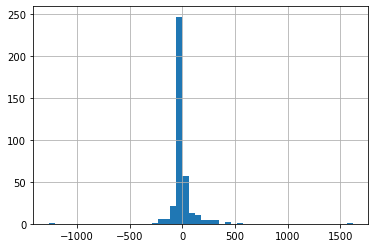

In [25]:
#histogram of pnl
random_strat.transaction_history['pnl'].hist(bins = 50)

# The portfolio_tracker records the # of bids, length of positions, cash value, position value, total value at each ti. 
# The bah column is the value assuming we buy all the tickers when it begins

In [26]:
random_strat.portfolio_tracker

,dt,bid_count,position_count,cash_value,positions_value,total_value,bah
0,2019-04-05 09:30:00,0,0,100000.00,0.00,100000.00,100000.000000
1,2019-04-05 09:30:00,10,9,5113.15,94886.85,100000.00,99856.000000
2,2019-04-05 09:31:00,0,9,5113.15,94851.05,99964.20,99866.790832
3,2019-04-05 09:32:00,0,9,5113.15,94801.30,99914.45,99926.823833
4,2019-04-05 09:33:00,0,9,5113.15,94717.03,99830.18,99827.385857
...,...,...,...,...,...,...,...
8837,2019-04-23 16:26:00,0,0,103662.35,0.00,103662.35,100606.956988
8838,2019-04-23 16:27:00,0,0,103662.35,0.00,103662.35,100578.631615
8839,2019-04-23 16:28:00,0,0,103662.35,0.00,103662.35,100571.295174
8840,2019-04-23 16:29:00,0,0,103662.35,0.00,103662.35,100562.975929


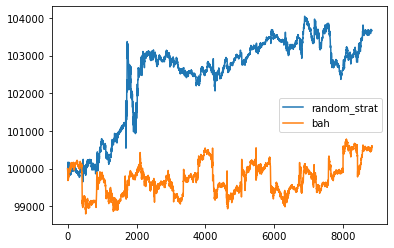

In [27]:
plt.plot(random_strat.portfolio_tracker['total_value'], label = 'random_strat')
plt.plot(random_strat.portfolio_tracker['bah'],label = 'bah')
plt.legend()

# 

# Upload to dashboard
## the upload_to_dashboard method will upload this graph to dashboard.
## make sure the crediential file "algo-trade-dashboard-80cae071e907.json" is under current directory, also install the related packages in requirements.txt

## to upload, call the function with the strategy name, if the name already exist in the gcloud, the previous data will be overwritten

In [16]:
random_strat.upload_to_dashboard("random_demo_0912")

Data uploaded.


# Check on dashboard:
https://tigaji-algo-trade-dashboard-dashboard-gv8r0a.streamlitapp.com/